In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, torch, gpytorch

In [13]:
dim = 1
param_space = { 
    'min' : np.zeros(dim), 
    'max' : np.ones(dim)
}


In [14]:
import sys
sys.path.append("/home/numerik/pvillani/Project/lipschitz/code/")

In [15]:
from utils.utils import latin_hypercube_sampling as lhs

In [16]:
from models.forward import forward_model as fm
from models.GP_models.MTSurrogate import MTModel
from models.lipschitz import lipschitz_regressor

In [73]:
x = np.array([0.05, 0.2, 0.3, 0.15, 0.6, 0.8, 0.9, 0.99]).reshape((-1,dim))

In [74]:
def mod(x):
    return np.exp( 5 * (x+0.2) )

In [75]:
forward = fm(2, "U")
true = mod(x)

In [80]:
noise_level = 0.2*np.ones_like(x[:,0]) #np.abs(np.random.normal(0, 0.2, size = len(true)) )
y = np.random.uniform(true.T-noise_level,true.T+ noise_level).T
train_y = np.random.normal(loc = true.T, scale = noise_level/2 ).T

In [77]:
x.shape

(8, 1)

In [ ]:
# initialize likelihood and model

GP = MTModel()
GP.fit(x, train_y, noise = noise_level**2/4)


In [23]:
test = np.linspace(0,1, 100)
x_test = test.reshape((-1,1) )

X, Y = np.meshgrid(test, test)
X = X.reshape((-1))
Y = Y.reshape((-1))
x_test = np.transpose([X,Y])

#mean, std = GP.predict(x_test, return_std = True)

In [86]:
lips = lipschitz_regressor(x[x<=0.8], y[x<=0.8], noise_level[np.all(x<=0.8,axis = 1)])
pred, low_bd, up_bd = lips.predict(test[test<=0.8], return_bds=True)

In [ ]:
lips = lipschitz_regressor(x[x>0.8], y[x<0.8], noise_level[np.all(x<0.8,axis = 1)])
pred, low_bd, up_bd = lips.predict(test[test<0.8], return_bds=True)

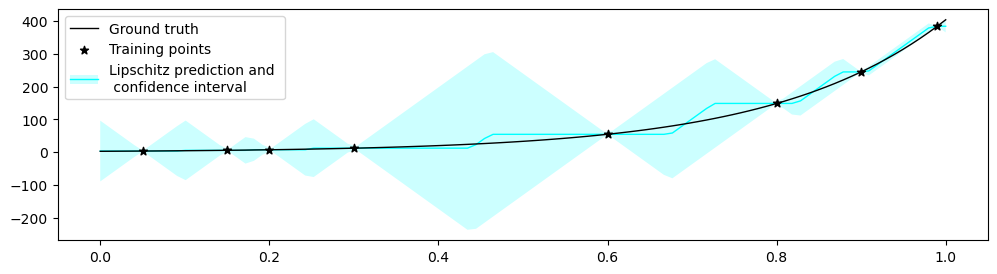

In [84]:
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(test, mod(test), 'black', lw = 1, label = "Ground truth", zorder = 8)

ax.scatter(x, y, color = 'black', marker = '*', label = 'Lipschitz training points', zorder = 10)
#ax.scatter(x, train_y, color = 'red', marker = '*', label = 'GP training points', zorder = 10)
#plt.axhline(meas)
#plt.axhline(meas + 2 * eps_l, linestyle="dashdot")
#plt.axhline(meas - 2 * eps_l, linestyle="dashdot")

# ax.plot(test, mean, 'blue', lw = 1, label="GP predictive mean and \n 95% confidence interval")
# ax.fill_between(
#     test.ravel(),
#     np.reshape(mean - 1.96 * std, -1),
#     np.reshape(mean + 1.96 * std, -1),
#     alpha=0.2,
#     label="GP predictive mean and \n 95% confidence interval",
#     facecolor= 'blue'
# )

ax.plot(test, pred, 'cyan', lw = 1, label ="Lipschitz prediction and \n confidence interval")
ax.fill_between(
    test.ravel(),
    low_bd[:,0],
    up_bd[:,0],
    alpha=0.2,
    label="Lipschitz prediction and \n confidence interval",
    facecolor= 'cyan'
)
handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],), (handler[1],),
      (handler[2],handler[3]), 
     ]
lab = ["Ground truth", 'Training points', "Lipschitz prediction and \n confidence interval", ]
ax.legend(hd, lab, )
#loc = 'upper right', prop={'size': 16} )
fig.savefig("model_comparison.svg", format = 'svg', transparent = True)


In [ ]:
plt.contourf(test,test, np.reshape(forward.predict(x_test)[:,0], (100,100)), 500 )
plt.colorbar()

In [ ]:
plt.contourf(test,test, np.reshape(pred[:,1], (100,100)),500 )
plt.colorbar()
plt.scatter(x[:,0], x[:,1])

In [ ]:
pred.shape

In [18]:
meas = np.array( [[-0.4]])
eps_l = np.array([0.05])

In [ ]:
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(test, forward.predict(test), 'black', lw = 1, label = "Ground truth", zorder = 8)

ax.scatter(x, y, color = 'black', marker = '*', label = 'Lipschitz training points', zorder = 10)
#ax.scatter(x, train_y, color = 'red', marker = '*', label = 'GP training points', zorder = 10)
plt.axhline(meas)
plt.axhline(meas + 2 * eps_l, linestyle="dashdot")
plt.axhline(meas - 2 * eps_l, linestyle="dashdot")

ax.plot(test, mean, 'blue', lw = 1, label="GP predictive mean and \n 95% confidence interval")
ax.fill_between(
    test.ravel(),
    np.reshape(mean - 1.96 * std, -1),
    np.reshape(mean + 1.96 * std, -1),
    alpha=0.2,
    label="GP predictive mean and \n 95% confidence interval",
    facecolor= 'blue'
)

ax.plot(test, pred, 'cyan', lw = 1, label ="Lipschitz prediction and \n confidence interval")
ax.fill_between(
    test.ravel(),
    low_bd[:,0],
    up_bd[:,0],
    alpha=0.2,
    label="Lipschitz prediction and \n confidence interval",
    facecolor= 'cyan'
)
# handler, labeler = ax.get_legend_handles_labels()
# hd = [(handler[0],), (handler[1],),
#       (handler[2],handler[3]), 
#       (handler[4],handler[5]),
#      ]
# lab = ["Ground truth", 'Training points',"GP predictive mean and \n 95% confidence interval", "Lipschitz prediction and \n confidence interval", ]
# ax.legend(hd, lab, )
    #loc = 'upper right', prop={'size': 16} )
#fig.savefig("model_comparison.svg", format = 'svg', transparent = True)


In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
from likelihoods.likelihoods import lipschitz_likelihood, GP_likelihood

In [22]:
liplike = lipschitz_likelihood(meas, eps_l**2, lips)
GPlike = GP_likelihood(meas, eps_l**2, GP)

In [ ]:
fig, ax = plt.subplots(figsize = (12,3))
lip_plugin = liplike.plugin(test)
lip_plugin /= lip_plugin.sum()
ax.plot(test, lip_plugin, lw = 1, label = "Lipschitz plugin")
lip_marginal = liplike.marginal(test)
lip_marginal /= lip_marginal.sum()
ax.plot(test, lip_marginal, lw = 1, label = "Lipschitz marginal")
GP_plugin = GPlike.plugin(x_test)
GP_plugin /= GP_plugin.sum()
ax.plot(test, GP_plugin, lw = 1, label = "GP plugin")
GP_marginal = GPlike.marginal(x_test)
GP_marginal /= GP_marginal.sum()
ax.plot(test, GP_marginal, lw = 1, label = "GP marginal")
GPlike.model = forward
truth = GPlike.plugin(test)
truth /= truth.sum()
ax.plot(test, truth, lw = 1, label = "Ground truth")
plt.legend()

In [ ]:
pred.shape

In [ ]:
x.shape

In [ ]:
x2 =x**2
np.sqrt(x2 + x2.transpose() - 2 *x.dot(x.transpose() ))

In [ ]:
from scipy.spatial.distance import cdist
cdist(x,x)

In [266]:
dy = y.reshape( (len(y[0]), -1, len(y) ))

In [ ]:
y2 =dy**2
np.sqrt(y2 + y2.transpose((0,2,1)) - 2 *dy.transpose((0,2,1) ).dot(dy )[:,:,0,:])

In [ ]:
dy.transpose((0,2,1) ).dot(y.transpose() ).shape

In [ ]:
dy.shape

In [ ]:
dx = x.reshape((len(x[0]), -1, len(x) ))
dx.transpose((0,2,1) ).dot(x.transpose() ).shape

In [101]:
x = lhs( 0, 1, 5).reshape((-1,1))

In [102]:
forward = fm(1, "U")
true = forward.predict(x)

In [103]:
noise = np.ones_like(true) * 0.05
y = np.random.uniform(true-noise,true+ noise)
noise0 = noise

In [109]:
nx =  lhs( 0.2, 0.8, 5).reshape((-1,1))
ny, _ = forward.predict(nx, noise0)
noise = np.concatenate( (noise, noise0) )

In [110]:
x = np.concatenate( (x,nx) )
y = np.concatenate( (y,ny) )

In [111]:
x2 = np.sum(x**2, axis = 1, keepdims=True)
xxT = x.dot(x.transpose())
dist_x = np.sqrt( x2 + x2.transpose() - 2 *xxT )

yT=y.transpose()

yT = yT.reshape( (len(yT), len(yT[0]), -1 ))

dist_y = np.abs(yT - yT.transpose((0,2,1)))

In [112]:
true_dist_x = np.zeros_like(dist_x)
true_dist_y = np.zeros_like(dist_y)
for i in range(3) :
    for j in range(3) :
        true_dist_x[i,j] = np.linalg.norm(x[i]-x[j])
        true_dist_y[:,i,j] = np.abs(y[i] - y[j] )

In [ ]:
eps = noise.reshape((len(y), -1))
eps2 = (eps + eps.transpose())

L_mat = (dist_y )/dist_x - eps2/dist_x

L = np.nanmax(L_mat, axis=(1,2), )
L

In [ ]:
true_dist_y

In [ ]:
dist_y

In [57]:
noise = np.concatenate( (noise, noise) )

In [ ]:
t = np.linspace(0,1,1000)
f = (2*t-1) *np.sin(4*t+1) + 4 * (1-t+t**2) * np.cos(4*t+1)
plt.plot(t,f)

In [122]:
intf = np.array( [ np.sum(f[:i])/len(f) for i in range(len(f) ) ] )

In [ ]:
err = forward.predict(t).reshape(-1) - intf
err -= err.mean()
plt.plot(t, err  )

In [130]:
from scipy.stats import norm

In [225]:
tau = 4

def D(s) :
    upper_term = 2*norm.cdf(-tau/s) 

    discr = np.linspace(-tau, tau, 3000).reshape((1,-1))
    sT = s.reshape( (-1,1) )

    diff = np.abs( 0.5/tau - 1/ sT * norm.pdf(discr/sT) )
    
    lower_term = 2*tau * np.mean( diff, axis = 1)
    return upper_term + lower_term

In [226]:
t = np.linspace(0.1, 5, 2000)

In [ ]:
plt.plot(t, D(t) )
plt.axvline(tau*2/3)

In [ ]:
a = np.argmin(D(t) )
t[a]

In [401]:
x = np.array([[0.0],[ 0.5]])
y = np.array([[0.0],[ 0.1]])
eps = 0.5
noise = np.array([[eps],[ eps]])
lips = lipschitz_regressor(x, y, noise)
lips.L = np.array([1])

C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: invalid value encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x
C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: divide by zero encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x


In [403]:
p = np.array([[0.25]])
_, LB, UB = lips.predict(p, return_bds=True)

In [343]:
from copy import deepcopy

In [404]:
n = 100
discr_ep = np.linspace(-eps, eps,n)
discr_pr =np.linspace(LB, UB, n)

qs = np.array([[[0.35]],[[0.0]],[[0.1]]])
integ = np.zeros(3)

i = 0
for q in qs :
    _, LBq, UBq = lips.predict(q, return_bds=True)
    for ep in discr_ep :
        for pr in discr_pr :
            lips1 = deepcopy(lips)
            lips1.update(p, pr+ep, np.array([[eps]]))
            lips1.L = np.array([1])
            _, nLBq, nUBq =  lips1.predict(q, return_bds=True)

            integ[i] += np.max([[[0]], UBq-nUBq])/(n**2)
            integ[i] -= np.min([[[0]], LBq -nLBq])/(n**2)
    i +=1

In [405]:
q = qs.reshape( (-1,1))
_, LBq, UBq = lips.predict(q, return_bds=True)
from AL.acquisition import pos_EER
pos_EER(eps, p, q, lips)

array([0.64833333, 0.28816667, 0.50833333])

In [406]:
integ * (2*eps) *(UB-LB)

array([[0.65404931, 0.29329689, 0.51404931]])

In [409]:
a = np.ones(4)
B = np.random.normal(size=(3,4))
np.dot(B, a)

array([-1.30255525, -0.06737924,  1.10922569])

In [ ]:
alpha, LBq + np.abs(p-q)+eps

In [ ]:
UB,LB,eps

In [ ]:
eps * ( LB - alpha + eps) * (-LB + alpha + eps) + (2*eps)**3/6

In [224]:
from scipy.integrate import dblquad

In [290]:
def target( y , e) :
    return alpha - e- y

In [ ]:
dblquad( target, a = LB, b = UB, gfun = -eps, hfun = eps)

In [ ]:
2*eps*(alpha *(UB -LB) + 1/2 *(LB**2 - (UB)**2))

In [ ]:
UB

In [ ]:
np.array([True, True])* ~np.array([False, True])

In [ ]:
[]